# Read-out Error


In [90]:
# import packages
import numpy as np
import scipy as sp

import qiskit_aer.noise as noise
from qiskit_aer.noise.errors import coherent_unitary_error, amplitude_damping_error, ReadoutError
from qiskit.circuit.library import RXGate

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_aer.noise import NoiseModel

from sklearn.linear_model import LinearRegression

from qiskit.visualization import plot_histogram

In [4]:
def iteration(matrix, p):
	SIGN = np.array([[-1, 1], [1, -1]])

	p = np.array(p)
	
	p = p.reshape((2, 1))
	p = p * SIGN
	p = p + np.eye(2)

	# reshape matrices
	p_flattened = p.reshape((1, p.size)) # p.size = 4

	# recursively calculate dimensions
	matrix_new = np.ones((2 * matrix.shape[0], 2*matrix.shape[0]))

	for j in range(matrix.shape[0]):
		row = matrix[j].reshape((matrix[j].size, 1))
		prod = row * p_flattened
		matrix_new[(2*j)] = prod[:, 0:2].flatten()
		matrix_new[(2*j + 1)] = prod[:, 2:4].flatten()
	
	return matrix_new

def iteration_inverse(matrix, p):
	# number of possible outputs in new array
	n = int(matrix.shape[0] / 2)

	SIGN = np.array([[-1, 1], [1, -1]])

	p = np.array(p)

	p = p.reshape((2, 1))
	p = p * SIGN
	p = p + np.eye(2)

	# reshape matrices
	p_flattened = p.reshape((1, p.size)) # p.size = 4

	matrix_new = np.ones((n, n))

	for j in range(n):
		prod = np.zeros((n, 4))

		prod[:, 0:2] = matrix[(2*j)].reshape((n, 2))
		prod[:, 2:4] = matrix[(2*j + 1)].reshape((n, 2))

		# compute the row
		row = (prod[:, 0] / p_flattened[0, 0]).T

		matrix_new[j] = row

	return matrix_new

def compute_matrix_iterative(X):
	"""
	args:
		X: np.darray (Nx2) probability of false result listed from most to least significant bit
	returns:
		output: np.darray (2^N x 2^N) matrix of readout errors
	"""
	# cast to np array
	try:
		X = np.array(X)
	except Exception as exception:
		print("Must pass in valid datatype: array of numbers.")
		print(exception)
	
	# check array dimensions
	D = X.shape[1]
	if D != 2:
		raise ValueError("Input probabilities must be in form [[probability of error when prepared 0, probability of error when prepared 1], ...]")

	# number data points
	N = X.shape[0]

	output = np.ones((1, 1))

	# goal shape: 2^N x 2^N
	for i in range(N):
		output = iteration(output, X[i])

	return output

In [5]:
probabilities = [
    [0.01, 0.03]
]
compute_matrix_iterative(probabilities)

array([[0.99, 0.01],
       [0.03, 0.97]])

In [6]:
probabilities = [
    [0.01, 0.03],
    [0.05, 0.02]
]
m = compute_matrix_iterative(probabilities)
print(m)

[[9.405e-01 4.950e-02 9.500e-03 5.000e-04]
 [1.980e-02 9.702e-01 2.000e-04 9.800e-03]
 [2.850e-02 1.500e-03 9.215e-01 4.850e-02]
 [6.000e-04 2.940e-02 1.940e-02 9.506e-01]]


In [7]:
iteration_inverse(m, probabilities[1])

array([[0.99, 0.01],
       [0.03, 0.97]])

In [8]:
def string_to_int_array(X):
    return np.array(list(X)).astype("i")

In [ ]:
def get_probabilities_of_one(data):
	"""
	args:
		data (dict) dictionary of {"outcome": counts}

	returns:
		probabilities (1xN array) the value at index i is the probability of measuring a 1 for qubit i
	"""

	N = len(list(data.keys())[0])
	
	total_counts = np.zeros(N)

	for key in list(data.keys()):
		counts = data[key]

		arr = string_to_int_array(key)
		
		total_counts = total_counts + (counts * arr)
	
	nshots = np.sum(list(data.values()))

	probabilities = total_counts / nshots

	return probabilities

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression

X = np.array([[0.1, 0.2], [0.3, 0.4]])
Y = X
reg = LinearRegression().fit(X, Y)
reg.coef_

array([[0.5, 0.5],
       [0.5, 0.5]])

In [39]:
reg.coef_ @ X

array([[0.2, 0.3],
       [0.2, 0.3]])

In [11]:
def get_false_probability(backend, N:int, nshots:int):
	""" 
	Computes the readout error matrix for N qubits.
	
	args:
		backend (FakeBackend): 	given backend
		N (int):				number qubits
		nshots:					optional number of shots to take in computation
		
	returns:
		zipped: 				N x 2 probability of false positive/negative results
	"""
	zeros = QuantumCircuit(N)
	zeros.measure_all()

	ones = QuantumCircuit(N)
	ones.x(list(range(N)))
	ones.measure_all()
	
	noise_model = NoiseModel.from_backend(backend)
	sampler = Sampler(options={
		'backend_options': {
			'noise_model': noise_model
		}
	})

	zeros_transpiled = transpile(zeros, backend)
	zeros_job = sampler.run([zeros_transpiled], shots=nshots)
	zeros_pub_result = zeros_job.result()[0]

	zeros_counts = zeros_pub_result.data.meas.get_counts()


	ones_transpiled = transpile(ones, backend)
	ones_job = sampler.run([ones_transpiled], shots=nshots)
	ones_pub_result = ones_job.result()[0]

	ones_counts = ones_pub_result.data.meas.get_counts()

	ones_false_probs = 1 - get_probabilities_of_one(ones_counts)
	zeros_false_probs = get_probabilities_of_one(zeros_counts)

	zipped = np.array([zeros_false_probs, ones_false_probs]).T
	
	return zipped

def get_calibration_matrix(backend, N:int, nshots:int=1024):
	"""
	Computes the readout error matrix for N qubits.
	
	args:
		backend (FakeBackend): 	given backend
		N (int):				number qubits
		nshots:					optional number of shots to take in computation
		
	returns:
		calibration_matrix (2^N x 2^N):	matrix to be applied to results for readout error mitigation.
	"""
	zipped = get_false_probability(backend, N, nshots)
	error_matrix = compute_matrix_iterative(zipped)

	# perform LU factorization
	P, L, U = sp.linalg.lu(error_matrix.T)

	# invert the L and U matrices
	L_inv = sp.linalg.inv(L)
	U_inv = sp.linalg.inv(U)

	# compute inverse
	calibration_matrix = U_inv @ L_inv

	return calibration_matrix

In [12]:
def to_string(x:int, N:int):
	return str(bin(x)).replace("0b", "").zfill(N)

def to_vector(counts:dict):
	""" 
	Returns a vector of the counts, where the ith position is number of counts for result 0bi.

	"""
	N = len(list(counts.keys())[0])
	keys = list(counts.keys())

	vector = np.zeros(2**N)
	
	for i in range(0, 2**N):
		key = to_string(i, N)

		if key in keys:
			vector[i] = counts[key]

	return vector

def to_dict(vector):
	counts = {}
	total_states = vector.shape[0]
	N = int(np.log2(total_states))

	for i in range(0, total_states):
		key = to_string(i, N)
		value = round(vector[i])
		if value != 0:
			counts[key] = round(vector[i])

	return counts

## Basic Readout Error

We consider a simple case of read-out error mitigation.

In [88]:
backend = AerSimulator.from_backend(FakePerth())

N = 7
calibration_matrix = get_calibration_matrix(backend, N)

## Testing

In [136]:
x = np.array([[1, 2], [3, 4]])
x / np.sum(x, axis=1)[:, None]

array([[0.33333333, 0.66666667],
       [0.42857143, 0.57142857]])

In [78]:
# define the circuit
from qiskit.circuit.random import random_circuit

nshots = 1024
 
# generate a random circuit
circuit = random_circuit(N, 1, measure=True)
circuit.draw()

┌──────┐           ┌─┐                  
q_0: ──────┤1     ├───────────┤M├──────────────────
           │      │      ┌───┐└╥┘┌─┐               
q_1: ──────┤  Dcx ├──────┤ Y ├─╫─┤M├───────────────
           │      │      └─┬─┘ ║ └╥┘┌─┐            
q_2: ──────┤0     ├────────┼───╫──╫─┤M├────────────
          ┌┴──────┴┐       │   ║  ║ └╥┘┌─┐         
q_3: ─────┤0       ├───────┼───╫──╫──╫─┤M├─────────
          │  Iswap │       │   ║  ║  ║ └╥┘┌─┐      
q_4: ─────┤1       ├───────┼───╫──╫──╫──╫─┤M├──────
     ┌────┴────────┴────┐  │   ║  ║  ║  ║ └╥┘┌─┐   
q_5: ┤ R(4.8482,3.1423) ├──┼───╫──╫──╫──╫──╫─┤M├───
     └──────────────────┘  │   ║  ║  ║  ║  ║ └╥┘┌─┐
q_6: ──────────────────────■───╫──╫──╫──╫──╫──╫─┤M├
                               ║  ║  ║  ║  ║  ║ └╥┘
c: 7/══════════════════════════╩══╩══╩══╩══╩══╩══╩═
                               0  1  2  3  4  5  6

In [134]:
nshots = 1024

In [135]:
# get ideal results
ideal_backend = AerSimulator()

ideal_transpiled = transpile(circuit, ideal_backend)
ideal_result = ideal_backend.run(ideal_transpiled, shots=nshots).result()
ideal_counts = ideal_result.get_counts(ideal_transpiled)
ideal_counts

{'0100000': 438, '0000000': 586}

In [136]:
# get the noisy results
noisy_backend = FakePerth()
noise_model = NoiseModel.from_backend(noisy_backend)
sampler = Sampler(options={
    'backend_options': {
        'noise_model': noise_model
	}
})

noisy_transpiled = transpile(circuit, noisy_backend)
noisy_job = sampler.run([noisy_transpiled], shots=nshots)
noisy_pub_result = noisy_job.result()[0]
noisy_counts = noisy_pub_result.data.c.get_counts()

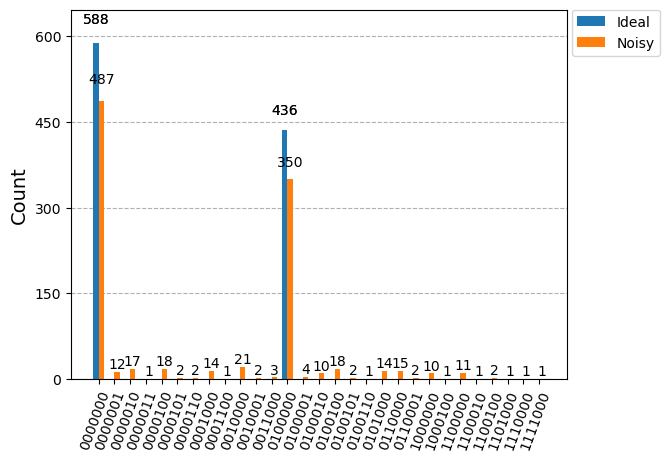

In [ ]:
plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

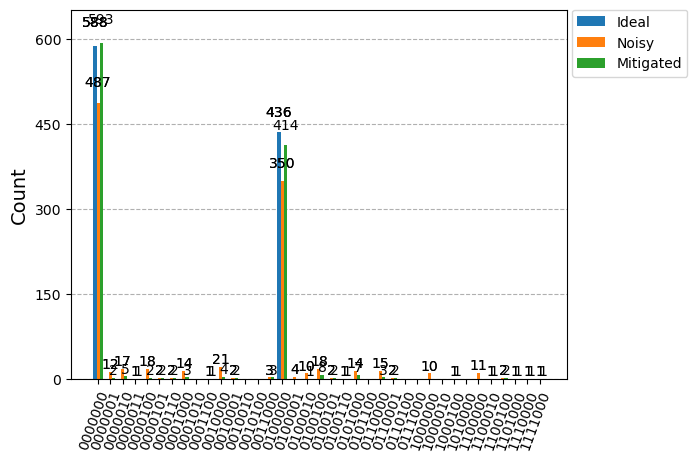

In [82]:
# mitigate the noisy results
noisy_probabilities = to_vector(noisy_counts) / nshots
mitigated_probabilities = calibration_matrix @ noisy_probabilities
mitigated_counts = to_dict(mitigated_probabilities * nshots)

# plot mitigated versus ideal
plot_histogram([ideal_counts, noisy_counts, mitigated_counts], legend=["Ideal", "Noisy", "Mitigated"])

## Iterative Readout Error Model Personalization

In [124]:
x = np.array([[1, 2], [3, 4], [5, 6]])
y = x.reshape((6, 1))
SIGN = np.array([[-1, 1], [1, -1]])

t = np.zeros((8, 2))
t = np.tile(SIGN, (3, 1))
y * t

np.tile(np.eye(2), (3, 1))

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [129]:
x = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
x.reshape((2, 2, 2))

array([[1, 2],
       [3, 4]])

In [98]:
def unfold_false_probabilities(X, N):
	SIGN = np.array([[-1, 1], [1, -1]])
	flattened = X.reshape((2*N, 1))
	mask = np.tile(SIGN, (N, 1))
	probabilities = flattened * mask + np.tile(np.eye(2), (N, 1))
	probabilities = probabilities.reshape((N, 2, 2)) # reshape
	return probabilities

def fold_false_probabilities(X):
	return X.diagonal(axis1=1, axis2=2)

In [137]:
def personalize(backend, N:int, circuits:list, nshots:int=1024, alpha=0.2):
    # obtain initial probabilities
	init_probabilities = get_false_probability(backend, N, nshots) # Nx2

	# convert into Nx4 matrix of all probabiliies
	probabilities = unfold_false_probabilities(init_probabilities, N)

	noise_model = NoiseModel.from_backend(backend)
	noisy_sampler = Sampler(options={
		'backend_options': {
			'noise_model': noise_model
		}
	})

	ideal_backend = AerSimulator()

	# number test data points
	D = len(circuits)
	training_x = np.zeros((N, 2, D))
	training_y = np.zeros((N, 2, D))

	print("Obtaining data...")
	iteration = 0

	# obtain training data
	for circuit in circuits:
		if iteration % 10 == 0:
			print(f"Iteration {iteration} of {len(circuits)}")
		
        # get ideal circuit vector
		ideal_transpiled = transpile(circuit, ideal_backend)
		ideal_result = ideal_backend.run(ideal_transpiled, shots=nshots).result()
		ideal_counts = ideal_result.get_counts(ideal_transpiled)

		ideal_ones = get_probabilities_of_one(ideal_counts)
		ideal_zeros = 1 - ideal_ones
		x = np.array([ideal_zeros, ideal_ones]).T
		
		# get noisy circuit vector
		noisy_transpiled = transpile(circuit, backend)
		noisy_job = noisy_sampler.run([noisy_transpiled], shots=nshots)
		noisy_result = noisy_job.result()[0]
		noisy_counts = noisy_result.data.c.get_counts()
		
		noisy_ones = get_probabilities_of_one(noisy_counts)
		noisy_zeros = 1 - noisy_ones
		y = np.array([noisy_zeros, noisy_ones]).T

		for i in range(N):
			training_x[i, :, i] = x[i]
			training_y[i, :, i] = y[i]
		
		iteration += 1
	
	# train 
	print()
	print("Training...")
	for i in range(N):
		print(f"Qubit: {i}")
		x = training_x[i].T
		y = training_y[i].T

		reg = LinearRegression().fit(x, y)
		probabilities[i] = (1 - alpha) * probabilities[i] + alpha * reg.coef_
		
		# normalize
		probabilities[i] = probabilities[i] / np.sum(probabilities[i], axis=1)[:, None]
	
	updated_zipped = fold_false_probabilities(probabilities)

	error_matrix = compute_matrix_iterative(updated_zipped)

	# perform LU factorization
	P, L, U = sp.linalg.lu(error_matrix.T)

	# invert the L and U matrices
	L_inv = sp.linalg.inv(L)
	U_inv = sp.linalg.inv(U)

	# compute inverse
	calibration_matrix = U_inv @ L_inv

	return calibration_matrix

In [ ]:
def train(num_training_points, backend, N=7, depth=4):
	circuits = []

	for _ in range(num_training_points):
		circuit = random_circuit(N, depth, measure=True)
		circuits.append(circuit)
		
	personalized_calibration = personalize(backend, N, circuits, nshots=1024)
	return personalized_calibration

In [126]:
def mse(prob1, prob2):
	error = np.sum(np.square(np.abs(prob1 - prob2)))
	return error

def fidelity(counts_ideal, counts_exp):
	probs_ideal = to_vector(counts_ideal) / np.sum(list(counts_ideal.values()))
	probs_exp = to_vector(counts_exp) / np.sum(list(counts_exp.values()))
	total = 0.0
	for state in list(counts_ideal.keys()):
		index = int(state, 2)
		p_ideal = probs_ideal[index]
		p_exp = probs_exp[index]

		total += np.square(p_ideal - p_exp)
	return total

def hamming_distance(counts_ideal, counts_exp):
	distance = 0

	shots_ideal = np.sum(list(counts_ideal.values()))
	shots_exp = np.sum(list(counts_exp.values()))

	for state in list(counts_ideal.keys()):
		if state not in list(counts_exp.keys()):
			distance += counts_ideal[state] / shots_ideal
	
	for state in list(counts_exp.keys()):
		if state not in list(counts_ideal.keys()):
			distance += counts_exp[state] / shots_exp
		
	return distance
	

In [139]:
personalized_calibration = train(1_00, backend=FakePerth())

Obtaining data...
Iteration 0 of 100
Iteration 10 of 100
Iteration 20 of 100
Iteration 30 of 100
Iteration 40 of 100
Iteration 50 of 100
Iteration 60 of 100
Iteration 70 of 100
Iteration 80 of 100
Iteration 90 of 100

Training...
Qubit: 0
Qubit: 1
Qubit: 2
Qubit: 3
Qubit: 4
Qubit: 5
Qubit: 6


In [152]:
def test(backend, calibration_matrix, personalized_calibration, num_test_points, circuits=None, N=7, depth=4, nshots=1024):
	mitigated_mse_errors = np.zeros(num_test_points)
	mitigated_fidelities = np.zeros(num_test_points)
	mitigated_hamming_distances = np.zeros(num_test_points)

	personalized_mse_errors = np.zeros(num_test_points)
	personalized_fidelities = np.zeros(num_test_points)
	personalized_hamming_distances = np.zeros(num_test_points)

	for i in range(num_test_points):
		if circuits is None:
			circuit = random_circuit(N, depth, measure=True)
		else:
			circuit = circuits[i]
		
		# get ideal results
		ideal_backend = AerSimulator()

		ideal_transpiled = transpile(circuit, ideal_backend)
		ideal_result = ideal_backend.run(ideal_transpiled, shots=nshots).result()
		ideal_counts = ideal_result.get_counts(ideal_transpiled)
		ideal_probabilities = to_vector(ideal_counts) / nshots

		# get the noisy results
		noisy_backend = backend
		noise_model = NoiseModel.from_backend(noisy_backend)
		sampler = Sampler(options={
			'backend_options': {
				'noise_model': noise_model
			}
		})

		noisy_transpiled = transpile(circuit, noisy_backend)
		noisy_job = sampler.run([noisy_transpiled], shots=nshots)
		noisy_pub_result = noisy_job.result()[0]
		noisy_counts = noisy_pub_result.data.c.get_counts()
			  
		# mitigate the noisy results
		noisy_probabilities = to_vector(noisy_counts) / nshots
		mitigated_probabilities = calibration_matrix @ noisy_probabilities
		mitigated_counts = to_dict(mitigated_probabilities * nshots)

		personalized_probabilities = personalized_calibration @ noisy_probabilities
		personalized_counts = to_dict(personalized_probabilities * nshots)

		# calculate MSE error
		mitigated_mse_errors[i] = mse(ideal_probabilities, mitigated_probabilities)
		personalized_mse_errors[i] = mse(ideal_probabilities, personalized_probabilities)

		# calculate fidelity
		mitigated_fidelities[i] = fidelity(ideal_counts, mitigated_counts)
		personalized_fidelities[i] = fidelity(ideal_counts, personalized_counts)

		# calculate hamming distance
		mitigated_hamming_distances[i] = hamming_distance(ideal_counts, mitigated_counts)
		personalized_hamming_distances[i] = hamming_distance(ideal_counts, personalized_counts)
		
	return {
		'mitigated': (mitigated_mse_errors, mitigated_fidelities, mitigated_hamming_distances),
		'personalized': (personalized_mse_errors, personalized_fidelities, personalized_hamming_distances)
	}

In [154]:
nshots = 1024
# get ideal results
ideal_backend = AerSimulator()

circuit=random_circuit(7, 4, measure=True)

ideal_transpiled = transpile(circuit, ideal_backend)
ideal_result = ideal_backend.run(ideal_transpiled, shots=nshots).result()
ideal_counts = ideal_result.get_counts(ideal_transpiled)

# get the noisy results
noisy_backend = FakePerth()
noise_model = NoiseModel.from_backend(noisy_backend)
sampler = Sampler(options={
    'backend_options': {
        'noise_model': noise_model
	}
})

noisy_transpiled = transpile(circuit, noisy_backend)
noisy_job = sampler.run([noisy_transpiled], shots=nshots)
noisy_pub_result = noisy_job.result()[0]
noisy_counts = noisy_pub_result.data.c.get_counts()

In [149]:
# mitigate the noisy results
noisy_probabilities = to_vector(noisy_counts) / nshots
mitigated_probabilities = calibration_matrix @ noisy_probabilities
mitigated_counts = to_dict(mitigated_probabilities * nshots)

personalized_probabilities = personalized_calibration @ noisy_probabilities
personalized_counts = to_dict(personalized_probabilities * nshots)

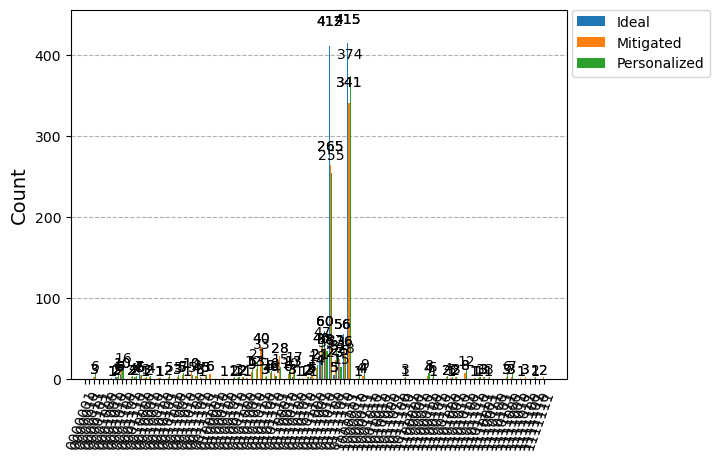

In [ ]:
# plot mitigated versus ideal
plot_histogram([ideal_counts, mitigated_counts, personalized_counts], legend=["Ideal", "Mitigated", "Personalized"])

In [ ]:
ideal_probs = to_vector(ideal_counts) / np.sum(list(ideal_counts.values()))
mitigated_probs = to_vector(mitigated_counts) / np.sum(list(mitigated_counts.values()))
personalized_probs = to_vector(personalized_counts) / np.sum(list(personalized_counts.values()))

In [155]:
print("MSE")
print(mse(ideal_probs, mitigated_probs))
print(mse(ideal_probs, personalized_probs))

print()
print("Fidelity")
print(fidelity(ideal_counts, mitigated_counts))
print(fidelity(ideal_counts, personalized_counts))

print()
print("Hamming distance")
print(hamming_distance(ideal_counts, mitigated_counts))
print(hamming_distance(ideal_counts, personalized_counts))

MSE
0.030717849731445312
0.03236916843869362

Fidelity
0.49975192489620623
0.4997500991830366

Hamming distance
1.5175809776655305
1.5175790777439029


In [ ]:
backend = FakePerth()
num_test_points = 100
outcome = test(backend, calibration_matrix, personalized_calibration, num_test_points=num_test_points)

In [160]:
import matplotlib.pyplot as plt

In [164]:
mitigated.shape

(100,)

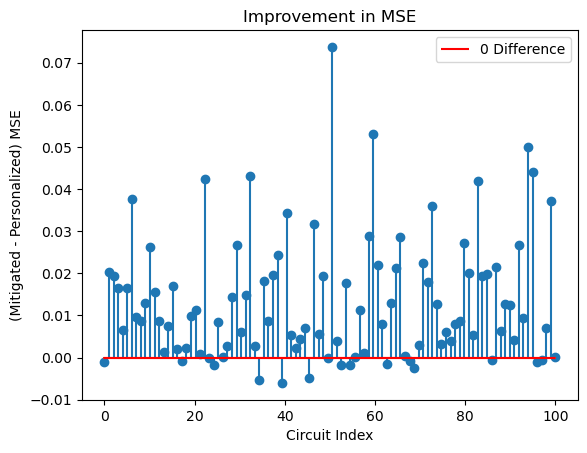

In [182]:
# plot the mse
mitigated = outcome['mitigated'][0]
personalized = outcome['personalized'][0]

difference = mitigated - personalized

x = np.linspace(0, num_test_points, num_test_points)
# plt.plot(x, difference, linestyle="-",)
plt.stem(x, difference)
plt.hlines(0, xmin=0, xmax=num_test_points, colors="red", label="0 Difference")
# plt.scatter(x, mitigated, label="Mitigated")
# plt.scatter(x, personalized, label='Personalized')
plt.legend()
plt.title("Improvement in MSE")
plt.xlabel("Circuit Index")
plt.ylabel("(Mitigated - Personalized) MSE")
plt.show()

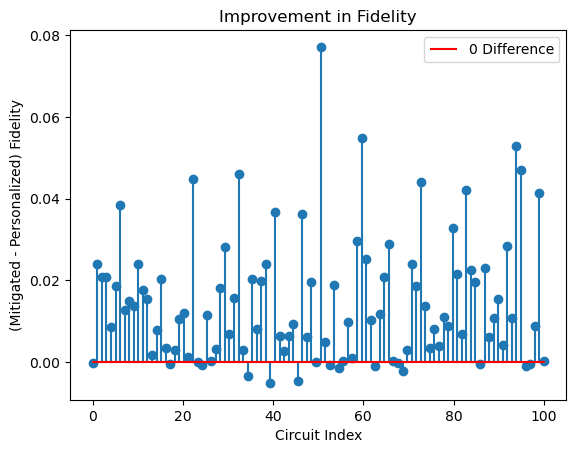

In [181]:
# plot the mse
mitigated = outcome['mitigated'][1]
personalized = outcome['personalized'][1]

difference = mitigated - personalized

x = np.linspace(0, num_test_points, num_test_points)
# plt.plot(x, difference, linestyle="-",)
plt.stem(x, difference)
plt.hlines(0, xmin=0, xmax=num_test_points, colors="red", label="0 Difference")
# plt.scatter(x, mitigated, label="Mitigated")
# plt.scatter(x, personalized, label='Personalized')
plt.legend()
plt.title("Improvement in Fidelity")
plt.xlabel("Circuit Index")
plt.ylabel("(Mitigated - Personalized) Fidelity")
plt.show()

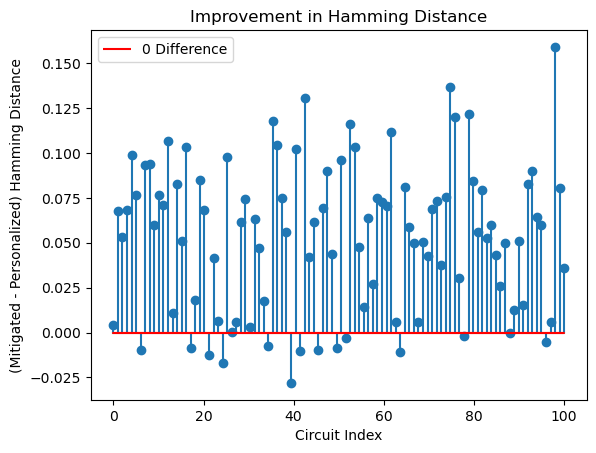

In [183]:
# plot the mse
mitigated = outcome['mitigated'][2]
personalized = outcome['personalized'][2]

difference = mitigated - personalized

x = np.linspace(0, num_test_points, num_test_points)
# plt.plot(x, difference, linestyle="-",)
plt.stem(x, difference)
plt.hlines(0, xmin=0, xmax=num_test_points, colors="red", label="0 Difference")
# plt.scatter(x, mitigated, label="Mitigated")
# plt.scatter(x, personalized, label='Personalized')
plt.legend()
plt.title("Improvement in Hamming Distance")
plt.xlabel("Circuit Index")
plt.ylabel("(Mitigated - Personalized) Hamming Distance")
plt.show()